## A- Imports e Data Loading

In [144]:
import pandas as pd
import numpy as np
import random
import pickle
import datetime
from scipy   import stats  as ss

import matplotlib.pyplot as plt 
import seaborn as sns

from IPython.core.display import HTML
from IPython.core.display import Image

from lightgbm              import LGBMRegressor
from sklearn               import metrics as mt
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

import warnings
warnings.filterwarnings( 'ignore' )


#### A.1 - Helper Functions

In [145]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )


def ml_error( model_name, y, yhat ):
    mae = mt.mean_absolute_error( y, yhat )
    mape = mt.mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mt.mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )
    
def cramer_v( x, y ):
    cm = pd.crosstab( x, y )
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )


def jupyter_settings():
    %matplotlib inline
    
    plt.style.use( 'seaborn-v0_8' )
    plt.rcParams['figure.figsize'] = [20, 10]
    plt.rcParams['font.size'] = 26
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

#### A.2- Loading Data

In [146]:
df_raw = pd.read_parquet('data/dados_compilados.parquet')

In [147]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 844338 entries, 0 to 1017190
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   store                         844338 non-null  int64         
 1   day_of_week                   844338 non-null  int64         
 2   date                          844338 non-null  datetime64[ns]
 3   sales                         844338 non-null  int64         
 4   promo                         844338 non-null  int64         
 5   state_holiday                 844338 non-null  object        
 6   school_holiday                844338 non-null  int64         
 7   store_type                    844338 non-null  object        
 8   assortment                    844338 non-null  object        
 9   competition_distance          844338 non-null  float64       
 10  competition_open_since_month  844338 non-null  int64         
 11  competition_open_

## 1.0 - Data Preparation

In [148]:
df1 = df_raw.copy()

### 1.1. Normalizacao

In [149]:
# Não haverá normalização pois as variáveis não possuem uma distribuição normal

### 1.2. Rescaling

In [150]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df1['competition_distance'] = rs.fit_transform( df1[['competition_distance']].values )
pickle.dump( rs, open( 'competition_distance_scaler.pkl', 'wb') )

# competition time month
df1['competition_time_month'] = rs.fit_transform( df1[['competition_time_month']].values )
pickle.dump( rs, open( 'competition_time_month_scaler.pkl', 'wb') )

# promo time week
df1['promo_time_week'] = mms.fit_transform( df1[['promo_time_week']].values )
pickle.dump( rs, open( 'promo_time_week_scaler.pkl', 'wb') )

# year
df1['year'] = mms.fit_transform( df1[['year']].values )
pickle.dump( mms, open( 'year_scaler.pkl', 'wb') )

### 1.3. Transformation

#### 1.3.1. Encoding

In [151]:
# state_holiday - One Hot Encoding
# df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# store_type - Label Encoding
le = LabelEncoder()
df1['store_type'] = le.fit_transform( df1['store_type'] )
pickle.dump( le, open( 'store_type_scaler.pkl', 'wb') )

df1['state_holiday'] = le.fit_transform( df1['state_holiday'] )
pickle.dump( le, open( 'state_holiday_scaler.pkl', 'wb') )

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
df1['assortment'] = df1['assortment'].map( assortment_dict )

#### 1.3.2. Response Variable Transformation

In [152]:
df1['sales'] = np.log1p( df1['sales'] )

<Axes: xlabel='sales', ylabel='Count'>

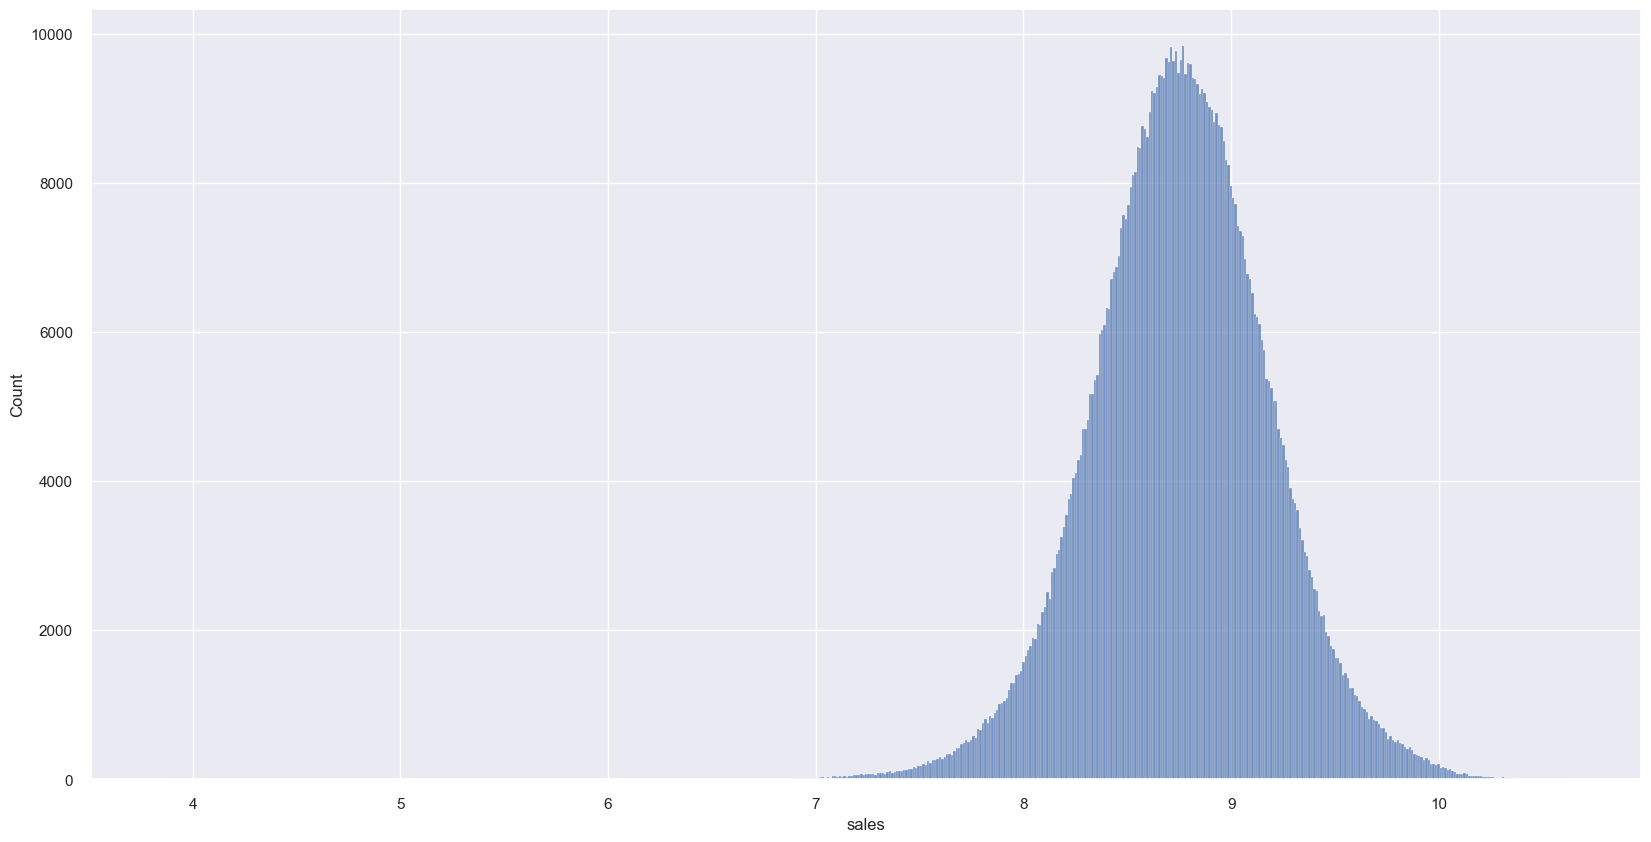

In [153]:
sns.histplot(df1.sales)

### 1.3.3. Nature Transformation (Cycle Feature)

In [154]:
# day of week
df1['day_of_week_sin'] = df1['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df1['day_of_week_cos'] = df1['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# month
df1['month_sin'] = df1['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df1['month_cos'] = df1['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day 
df1['day_sin'] = df1['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df1['day_cos'] = df1['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week of year
df1['week_of_year_sin'] = df1['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df1['week_of_year_cos'] = df1['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

## 2.0. Feature Selection

In [155]:
df2 = df1.copy()

### 2.1. Split dataframe into training and test dataset

In [156]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week' ]
df2 = df2.drop( cols_drop, axis=1 )

# training dataset
X_train = df2[df2['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df2[df2['date'] >= '2015-06-19']
y_test = X_test['sales']

print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


### 2.2. Manual Feature Selection

In [157]:
cols_selected = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_full = cols_selected.copy()
cols_selected_full.extend( feat_to_add )

## 3.0. Machine Learning Modeling

In [158]:
x_train = X_train[ cols_selected ]
x_test = X_test[ cols_selected ]

# Time Series Data Preparation
x_training = X_train[ cols_selected_full ]

### 3.1. Average Model

In [159]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Média Geral', np.expm1( y_test ), np.expm1( yhat_baseline ) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Média Geral,1354.800353,0.2064,1835.135542


### 3.2. Linear Regression Model

In [160]:
# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1868.420673,0.292886,2670.995649


#### 3.2.1. Linear Regression Model - Cross Validation

In [161]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.91 +/- 295.72,0.3 +/- 0.02,2951.27 +/- 468.66


### 3.3. Linear Regression Regularized Model - Lasso

In [162]:
# model
lrr = Lasso( alpha=0.0001 ).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1869.235937,0.292085,2675.935149


#### 3.3.1.  Lasso - Cross Validation

In [163]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2081.81 +/- 298.87,0.3 +/- 0.02,2954.66 +/- 471.48


### 3.4. Random Forest Regressor

In [164]:
# model
rf = RandomForestRegressor( n_estimators=150, n_jobs=-1 ).fit( x_train, y_train )

# prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,678.861854,0.099988,1010.841805


#### 3.4.1.  Random Forest Regressor - Cross Validation

In [165]:
rf_result_cv = cross_validation( x_training, 4, 'Random Forest Regressor', rf, verbose=True )
rf_result_cv


KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,746.27 +/- 133.01,0.11 +/- 0.02,1125.44 +/- 202.57


### 3.5. LightGBM Regressor

In [166]:
# model
lgbm_model = LGBMRegressor( n_estimators=2200, 
                            learning_rate=0.38, 
                            max_depth=24,
                            num_leaves=31
                            ).fit( x_train, y_train )

# prediction
yhat_lgbm = lgbm_model.predict( x_test )

# performance
lgbm_result = ml_error( 'LGBM Regressor', np.expm1( y_test ), np.expm1( yhat_lgbm ) )

lgbm_result

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1317
[LightGBM] [Info] Number of data points in the train set: 802942, number of used features: 20
[LightGBM] [Info] Start training from score 8.757218
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,Model Name,MAE,MAPE,RMSE
0,LGBM Regressor,655.815886,0.095169,953.947468


#### 3.5.1. LGBM Regressor - Cross Validation

In [167]:
lgbm_result_cv = cross_validation( x_training, 4, 'LGBM Regressor', lgbm_model, verbose=True )

lgbm_result_cv


KFold Number: 4
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1317
[LightGBM] [Info] Number of data points in the train set: 648309, number of used features: 20
[LightGBM] [Info] Start training from score 8.750168
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).

KFold Number: 3
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be ba

,Model Name,MAE CV,MAPE CV,RMSE CV
0,LGBM Regressor,828.38 +/- 146.07,0.12 +/- 0.01,1188.03 +/- 198.95


### 3.6. Compare Model's Performance

In [168]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, lgbm_result] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,LGBM Regressor,655.815886,0.095169,953.947468
0,Random Forest Regressor,678.861854,0.099988,1010.841805
0,Média Geral,1354.800353,0.206400,1835.135542
0,Linear Regression,1868.420673,0.292886,2670.995649
0,Linear Regression - Lasso,1869.235937,0.292085,2675.935149


#### 3.6.2. Real Performance - Cross Validation

In [169]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, lgbm_result_cv] )
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.91 +/- 295.72,0.3 +/- 0.02,2951.27 +/- 468.66
0,Lasso,2081.81 +/- 298.87,0.3 +/- 0.02,2954.66 +/- 471.48
0,Random Forest Regressor,746.27 +/- 133.01,0.11 +/- 0.02,1125.44 +/- 202.57
0,LGBM Regressor,828.38 +/- 146.07,0.12 +/- 0.01,1188.03 +/- 198.95


## 4.0. Model Performance

In [170]:
df4 = X_test[ cols_selected_full ]

# # rescale
df4['sales'] = np.expm1( df4['sales'] )
df4['predictions'] = np.expm1( yhat_lgbm )

### 4.1. Business Performance

In [171]:
def business_perf(df):

    # soma das previsões
    df1 = df[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

    # MAE and MAPE
    df_aux1 = df[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mt.mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'})
    df_aux2 = df[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mt.mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'})

    # Merge
    df_aux3 = pd.merge( df_aux1, df_aux2, how='inner', on='store' )
    df = pd.merge( df1, df_aux3, how='inner', on='store' )

    # Diferentes Cenários
    df['worst_scenario'] = df['predictions'] - (df['predictions'] * df['MAPE'])
    df['best_scenario'] = df['predictions'] + (df['predictions'] * df['MAPE'])

    df = df[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

    df = df.rename(columns={'store': 'Loja', 'predictions': 'previsão', 'worst_scenario': 'pior_cenário',
                             'best_scenario': 'melhor_cenário'})

    return df

In [172]:
df = business_perf(df4)
df.sort_values( 'MAPE', ascending=True )[['MAE', 'MAPE']].mean()

MAE     659.437808
MAPE      0.095572
dtype: float64

<Axes: xlabel='Loja', ylabel='MAPE'>

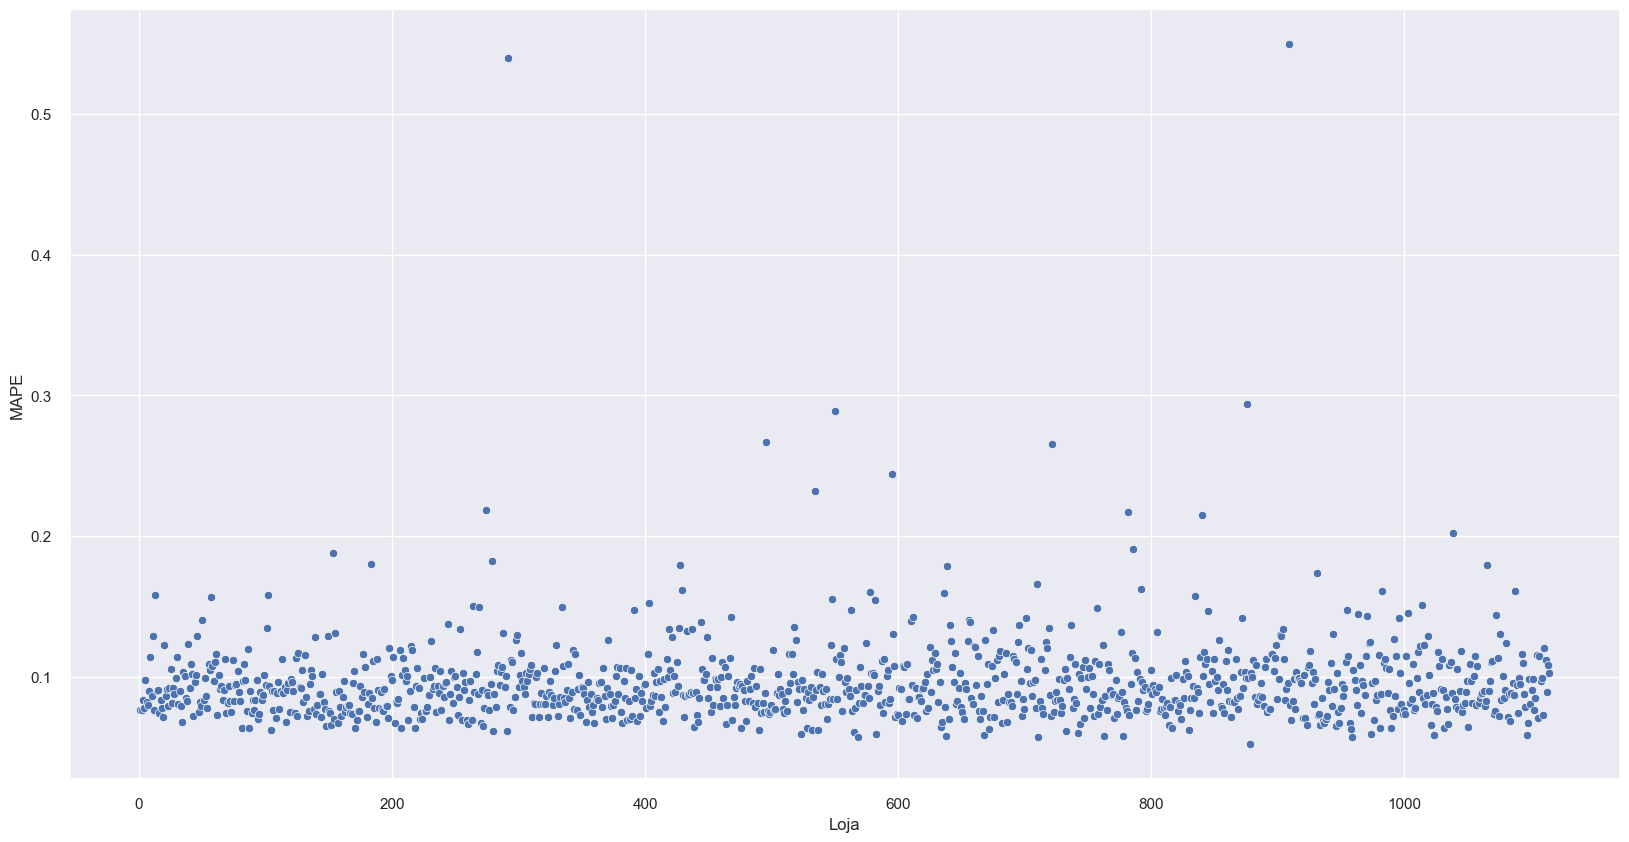

In [173]:
sns.scatterplot( x='Loja', y='MAPE', data=df )

### 4.2. Total Performance

In [174]:
df = df[['previsão', 'pior_cenário', 'melhor_cenário']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Cenários', 0:'Receita'} )
df['Receita'] = df['Receita'].map( 'R${:,.2f}'.format )
df

,Cenários,Receita
0,previsão,"R$287,070,497.92"
1,pior_cenário,"R$259,909,042.82"
2,melhor_cenário,"R$314,231,953.02"


### 4.3. Machine Learning Performance

<Axes: xlabel='predictions', ylabel='error'>

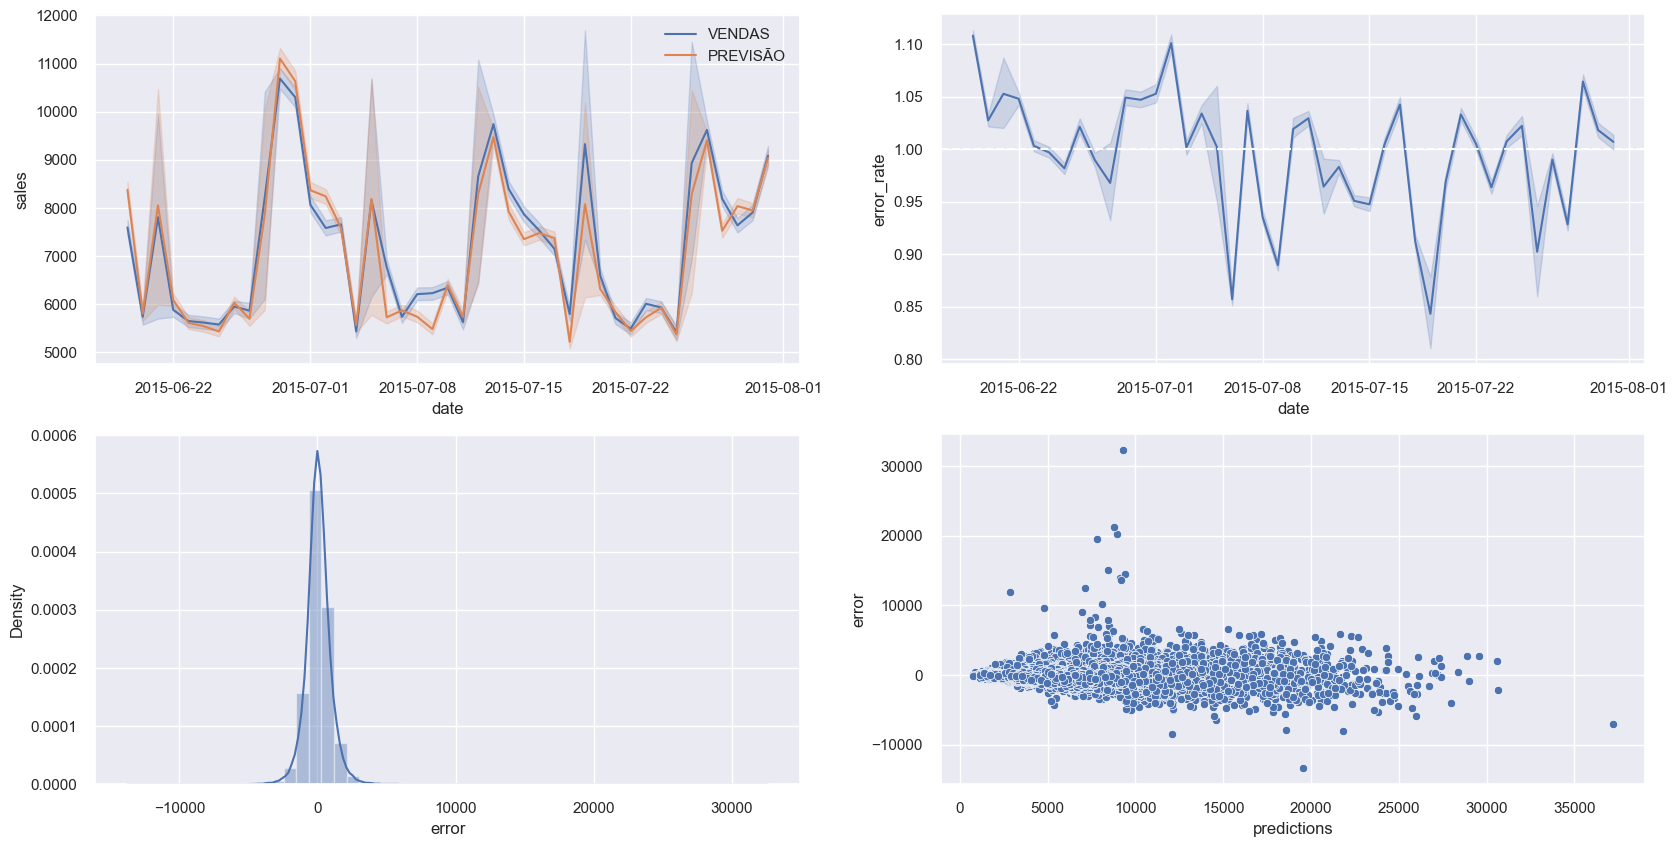

In [176]:
df4['error'] = df4['sales'] - df4['predictions']
df4['error_rate'] = df4['predictions'] / df4['sales']


plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df4, label='VENDAS' )
sns.lineplot( x='date', y='predictions', data=df4, label='PREVISÃO' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df4 )
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.distplot( df4['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( x=df4['predictions'], y=df4['error'] )